# Train floor number data with CNN

## Do setup

In [14]:
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
import os
%matplotlib inline

## load and display some data image

In [15]:
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 26
def extract_data(filename, num_images):
  """Extract the images into a 4D tensor [image index, y, x, channels].

  Values are rescaled from [0, 255] down to [-0.5, 0.5].
  """
  filepath = os.path.join(WORK_DIRECTORY, filename)
  print('Extracting', filepath)
  with open(filepath, mode='rb') as bytestream:
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
    data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
    data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data


def extract_labels(filename, num_images):
  """Extract the labels into a vector of int64 label IDs."""
  filepath = os.path.join(WORK_DIRECTORY, filename)
  print('Extracting', filepath)
  with open(filepath, mode='rb') as bytestream:
    buf = bytestream.read(1 * num_images)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.int64)
  return labels

# Get the data.
train_data_filename = 'floor_train_data.bin'
train_labels_filename = 'floor_train_label.bin'
test_data_filename = 'floor_test_data.bin'
test_labels_filename = 'floor_test_label.bin'

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 27863)
train_labels = extract_labels(train_labels_filename, 27863)
test_data = extract_data(test_data_filename, 7800)
test_labels = extract_labels(test_labels_filename, 7800)


Extracting data/floor_train_data.bin
Extracting data/floor_train_label.bin
Extracting data/floor_test_data.bin
Extracting data/floor_test_label.bin


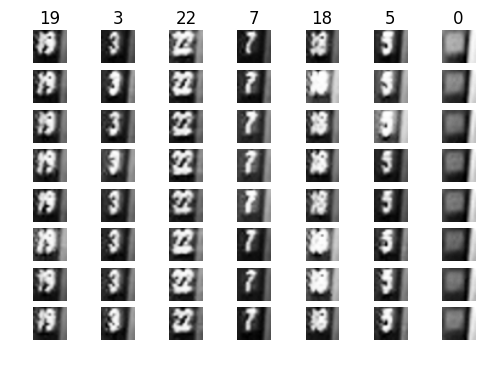

In [32]:
class_7 = np.random.choice([x for x in range(NUM_LABELS)], 7, replace=False)
for y, cls in enumerate(class_7):
    idxs = np.flatnonzero(train_labels == cls)
    idxs = np.random.choice(idxs, 8, replace=False) # chose 8 for each label
    #print(cls, idxs)
    for i, idx in enumerate(idxs):
        plt_idx = i * 7 + y + 1
        plt.subplot(8, 7, plt_idx)
        plt.imshow((train_data[idx,:,:,:] * PIXEL_DEPTH + PIXEL_DEPTH / 2.0).reshape((IMAGE_SIZE, IMAGE_SIZE)).astype('uint8'), \
                  cmap='gray')
        plt.axis('off')
        if i==0:
            plt.title(cls)

In [3]:
# define tensorflow CNN network

In [4]:
# overfit small data

In [5]:
# training